# Chi Square
---

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Import stats functions
from statsmodels.stats.power import GofChisquarePower

# MDE Derivation
---
Let us solve for the MDE for a single test group using what we know. Note that our power tool can solve for a normalized MDE (Cohen's *w*) for our system. However, we would like to disseect this value and find the minimal effect size for each independent test group in the experiment.

The normalized effect size for an experiment with binary outcome variable and multiple ($n>2$) experimental groups is Cohen's $w$. This value is derived using contingency tables, but do not require the *actual* values in each cell of the table. This is important, because the probabilities in each test cell allow us to abstract the derivation to situations in which we do not know sample size $N$. To get a better understanding, let's take a look at Cohen's $w$ equation:

$$w = \sqrt{\Sigma_i \frac{(E_i - O_i)^2}{E_i}},$$

where $E_i$ is the probability of cell $i$ under the Null hypothesis (i.e., the value expected if no treatment group experienced an effect) and $O_i$ is the probability of cell $i$ in the observed population. Comparing these two contingency tables ($O$ and $E$) allows us to test how likely the observed values were the effect of random chance alone.

To start, let's present a fully built-out set of contingency tables for our "system":

**Observed rates ($O_i$):**

Experimental Group | Success Rate (1) | Failure Rate (0) | *Marginal*
--- | --- | --- | ---
Treat 1 | $t_i \times (p+e_1)$ | $t_1 \times (1-p-e_1)$ | $t_1$
Treat 2 | $t_i \times (p+e_2)$ | $t_2 \times (1-p-e_2)$ | $t_2$
... | ... | ... | ...
Control | $t_n \times (p+e_n)$ | $t_n \times (1-p-e_n)$ | $t_n$
*Marginal* | $p + \Sigma_it_ie_i$ | $1-p-\Sigma_it_ie_i$ | $1$

**Expected rates ($E_i$):**

Experimental Group | Success Rate (1) | Failure Rate (0) | *Marginal*
--- | --- | --- | ---
Treat 1 | $t_i \times (p+\Sigma_it_ie_i)$ | $t_1 \times (1-p-\Sigma_it_ie_i)$ | $t_1$
Treat 2 | $t_i \times (p+\Sigma_it_ie_i)$ | $t_2 \times (1-p-\Sigma_it_ie_i)$ | $t_2$
... | ... | ... | ...
Control | $t_n \times (p+\Sigma_it_ie_i)$ | $t_n \times (1-p-\Sigma_it_ie_i)$ | $t_n$
*Marginal* | $p + \Sigma_it_ie_i$ | $1-p-\Sigma_it_ie_i$ | $1$

Note that we could specify an effect $e_i$ for each test cell. If we hold any one of these variables {$t_i$, $e_i$} constant, we can solve for it analytically using algebra. That is, we start with:

$$w = \sqrt{\Sigma_i\frac{(E_i-O_i)^2}{E_i}},$$

where we substitute $E_i$ and $O_i$ with our input above. *After lots of algebra...*

Variable | Description
--- | ---
$w$ | Cohen's $w$, as defined above
$j$ | Test group to "optimize"
$e_j$| Absolute effect of test group $j$
$t_j$ | Test split (i.e., percent of sample size) for test group $j$
$p$ | Natural rate of success
$X = \Sigma_i e_it_i$ | A constant that appears often in the algebraic output
$\Sigma^*_i$ | Summation across all test groups *excluding test group* $j$

***Second order polynomial used to solve for absolute effect size of test group $j$:***

$$0 = e_j^2[t_j^2(w^2-1)+t_j]+e_j[w^2t_j(2p-1)+2Xt_j(w^2-1)]+[w^2p(p-1)+2w^2Xp-w^2X(1-X)-X^2+(\Sigma^*_it_ie_i^2)]$$

***Second order polynomial used to solve for optimal test split of test group $j$:***
$$0 = t_j^2[e_j^2(w^2-1)]+t_j[e_j^2+e_jw^2(2p-1)+2Xe_j(w^2-1)]+[w^2p(p-1)+2w^2Xp-w^2X(1-X)-X^2+(\Sigma^*_it_ie_i^2)]$$

Those are some messy equestions ... Let's check that the math is correct.

Below we walk through checks to ensure the polynomial for aboslute effect size (MDE) is correct. First, we need to calculate Cohen's *w*:

In [2]:
def cohens_w(natural_rate, test_group_splits, test_group_lifts):
    assert round(test_group_splits.sum(), 4) == 1
    assert np.max(test_group_lifts + natural_rate) < 1. and np.min(test_group_lifts + natural_rate) > 0.
    
    observed_success = test_group_splits * (test_group_lifts + natural_rate)
    observed_failure = test_group_splits * (1 - test_group_lifts - natural_rate)
    
    observed_table = np.stack([observed_success, observed_failure])
    
    assert round(observed_table.sum(), 4) == 1.
    
    # Note that marginal success is `observed_table[0].sum()`
    expected_success = observed_table[0].sum() * test_group_splits
    expected_failure = observed_table[1].sum() * test_group_splits
    expected_table = np.stack([expected_success, expected_failure])
    
    assert round(expected_table.sum(), 4) == 1.
    
    w = np.sqrt(np.sum(np.square((expected_table-observed_table))/expected_table))
    return w

natural_rate_of_success = 0.35
experiment_splits = np.array([0.1, 0.2, 0.3, 0.4])
experiment_lifts = np.array([0.0, 0.04, 0.05, 0.07])
w = cohens_w(natural_rate_of_success, experiment_splits, experiment_lifts)
print("Cohen's w is:", w)

Cohen's w is: 0.04226131910509266


In the contingency tables above, we state that the marginal rate of success is $(p+\Sigma_it_ie_i)$ and the marginal rate of failure is $(1-p-\Sigma_it_ie_i)$.

Let's confirm this is truly the case to cover our initial assumptions:

In [4]:
def check_math_0(natural_rate, test_group_splits, test_group_lifts):
    observed_success = test_group_splits * (test_group_lifts + natural_rate)
    observed_failure = test_group_splits * (1 - test_group_lifts - natural_rate)
    
    observed_table = np.stack([observed_success, observed_failure])
    
    const = np.sum(test_group_splits * test_group_lifts)
    
    print("Marginal success:", observed_table[0].sum())
    print("(Natural rate + Const):", natural_rate + const)
    print("\nMarginal failure:", observed_table[1].sum())
    print("(1 - Natural rate - Const):", 1 - natural_rate - const)

check_math_0(natural_rate_of_success, experiment_splits, experiment_lifts)

Marginal success: 0.401
(Natural rate + Const): 0.40099999999999997

Marginal failure: 0.599
(1 - Natural rate - Const): 0.599


Let us show that:

$$w=\sqrt{\Sigma_i\frac{(E_i-O-i)^2}{E_i}} = \sqrt{\Sigma_i\frac{t_i(\Sigma_ke_kt_k-e_i)^2}{(p+\Sigma_ke_kt_k)(1-p-\Sigma_ke_kt_k)}}$$

In [5]:
def check_math_1(natural_rate, test_group_splits, test_group_lifts):
    w = cohens_w(natural_rate, test_group_splits, test_group_lifts)
    
    const = np.sum(test_group_splits * test_group_lifts)
    summation = 0
    for j, split in enumerate(test_group_splits):
        summation += split * np.square(const - test_group_lifts[j])
    summation /= ((natural_rate + const) * (1 - natural_rate - const))
    
    print("Cohen's w:", w)
    print("Algebraic output:", np.sqrt(summation))

check_math_1(natural_rate_of_success, experiment_splits, experiment_lifts)

Cohen's w: 0.04226131910509266
Algebraic output: 0.04226131910509263


Verify that the following holds:

$$w=\sqrt{\frac{e_j^2[t_j-t_j^2]+e_j[-2Xt_j]+[-X^2+\Sigma^*_it_ie_i^2]}{(p+X+e_jt_j)(1-p-E-e_jt_j)}}$$

In [19]:
def check_math_2(natural_rate, test_group_splits, test_group_lifts):
    w = cohens_w(natural_rate, test_group_splits, test_group_lifts)
    
    index = 2 # random 0-3
    e_j = test_group_lifts[index]
    t_j = test_group_lifts[index]
    
    X = np.sum(test_group_splits * test_group_lifts) - (e_j * t_j)
    other_const = np.sum(test_group_splits * test_group_lifts * test_group_lifts) - (t_j * e_j * e_j)
    
    a = e_j**2 * (t_j - t_j**2)
    b = e_j * -2 * X * t_j
    c = -1 * X**2 + other_const
    
    num = a + b + c
    denom = (natural_rate + X + e_j * t_j) * (1 - natural_rate - X - e_j * t_j)
    
    print("Cohen's w:", w)
    print("Algebraic output:", np.sqrt(num/denom))

check_math_2(natural_rate_of_success, experiment_splits, experiment_lifts)

Cohen's w: 0.04226131910509266
Algebraic output: 0.042261319105092635


Factoring the equation above out, we solve for the following polynomial:

$$0 = e_j^2[t_j^2(w^2-1)+t_j]+e_j[w^2t_j(2p-1)+2Xt_j(w^2-1)]+[w^2p(p-1)+2w^2Xp-w^2X(1-X)-X^2+(\Sigma^*_it_ie_i^2)]$$

In [22]:
def check_math_3(natural_rate, test_group_splits, test_group_lifts):
    w = cohens_w(natural_rate, test_group_splits, test_group_lifts)
    w2 = w**2
    
    index = 2 # random 0-3
    e_j = test_group_lifts[index]
    t_j = test_group_lifts[index]
    
    X = np.sum(test_group_splits * test_group_lifts) - (e_j * t_j)
    other_const = np.sum(test_group_splits * test_group_lifts * test_group_lifts) - (t_j * e_j * e_j)
    
    a = t_j**2 * (w2-1) + t_j
    b = w2 * t_j * (2*natural_rate-1) + 2 * X * t_j * (w2-1)
    c = w2 * natural_rate * (natural_rate-1) + 2 * w2 * X * natural_rate - w2 * X * (1-X) - X**2 + other_const
    
    output = e_j**2 * a + e_j * b + c
    
    print("Algebraic output: %.9f" % output)

check_math_3(natural_rate_of_success, experiment_splits, experiment_lifts)

Algebraic output: -0.000000000


# Test the derivation

Now that we have our polynomial we can solve for $e_j$, which is our absolute minimum effect size for test group $j$ given a minimal detect size for the entire system.

In [23]:
# Arbitrarily solve for first group in arrays (test split / lifts) passed; generalize to any group later
def solve_absolute_mde_roots(sample_size, group_splits, group_lifts, natural_rate, alpha=0.05, beta=0.20):
    w = GofChisquarePower().solve_power(
        nobs=sample_size
        ,power=(1-beta)
        ,alpha=alpha
        ,n_bins=len(group_splits)
    )
    w2 = w**2
    
    index = 0 # random 0-1
    e_j = group_lifts[index]
    t_j = group_splits[index]
    
    X = np.sum(group_splits * group_lifts) - (e_j * t_j)
    other_const = np.sum(group_splits * group_lifts * group_lifts) - (e_j * e_j * t_j)
    
    a = t_j**2 * (w2-1) + t_j
    b = w2 * t_j * (2*natural_rate-1) + 2 * X * t_j * (w2-1)
    c = w2 * natural_rate * (natural_rate-1) + 2 * w2 * X * natural_rate - w2 * X * (1-X) - X**2 + other_const
    
    roots = np.roots([a, b, c])
    return roots

sample_size = 3500
natural_rate_of_success = 0.65
experiment_splits = np.array([0.9, 0.1])
experiment_lifts = np.array([0.08, 0.0])
alpha = 0.05
power = 0.80

absolute_mde_roots = solve_absolute_mde_roots(
    sample_size
    ,experiment_splits
    ,experiment_lifts
    ,natural_rate_of_success
    ,alpha
    ,(1-power)
)
print("Absolute MDE roots are:", absolute_mde_roots)

Absolute MDE roots are: [-0.07791445  0.07131954]


These roots correspond with the minimal detectable effect in either direction of our natural resolution rate. If we were originally assuming an effect in the positive direction, we should take the positive root (`max`); otherwise, take the negative root (`min`).

Let's confirm that both of these roots get us to the desired power:

In [31]:
def solve_power(sample_size, experiment_splits, experiment_lifts, natural_rate_of_success, alpha):
    e = cohens_w(natural_rate_of_success, np.array(experiment_splits), np.array(experiment_lifts))
    power = GofChisquarePower().solve_power(
        effect_size=e
        ,nobs=sample_size
        ,alpha=alpha
        ,n_bins=len(experiment_splits)
    )
    return power

current_power = solve_power(sample_size, experiment_splits, experiment_lifts, natural_rate_of_success, alpha)
print("Originally, the power of our system is:", current_power)

Originally, the power of our system is: 0.8867205271525038


In [33]:
new_experiment_lifts__positive_root = np.array([np.max(absolute_mde_roots), 0.0])
new_experiment_lifts__negative_root = np.array([np.min(absolute_mde_roots), 0.0])

new_power__positive_root = solve_power(
    sample_size=sample_size
    ,experiment_splits=experiment_splits
    ,experiment_lifts=new_experiment_lifts__positive_root
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)
new_power__negative_root = solve_power(
    sample_size=sample_size
    ,experiment_splits=experiment_splits
    ,experiment_lifts=new_experiment_lifts__negative_root
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)

print("The desired power for our system is:", power)
print("The power of our system with the postivie root is:", new_power__positive_root)
print("The power of our system with the negative root is:", new_power__negative_root)

The desired power for our system is: 0.8
The power of our system with the postivie root is: 0.8000249787422251
The power of our system with the negative root is: 0.8000249787422256


## Side case: Complex roots

Because we are solving for a second-order polynomial, we may get into a scenario where these roots are complex. Let's examine this side case:

In [34]:
sample_size = 2800
experiment_splits = [0.4, 0.4, 0.2]
experiment_lifts = [0.06, 0.08, 0.0]
natural_rate_of_success = 0.65
alpha = 0.05
power = 0.80

absolute_mde_roots = solve_absolute_mde_roots(
    sample_size=sample_size
    ,group_splits=np.array(experiment_splits)
    ,group_lifts=np.array(experiment_lifts)
    ,natural_rate=natural_rate_of_success
    ,alpha=alpha
    ,beta=(1-power)
)
print("Absolute MDE roots are:", absolute_mde_roots)

Absolute MDE roots are: [0.05216989+0.02369241j 0.05216989-0.02369241j]


We can visualize the power as we vary the effect size for this test group:

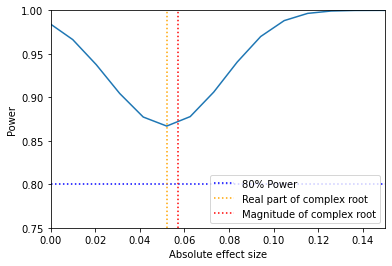

<Figure size 432x288 with 0 Axes>

In [35]:
imaginary_number = absolute_mde_roots[0]
norm = np.linalg.norm(imaginary_number)

x_axis = np.linspace(norm-0.1, norm+0.1, 20)
y_axis = [
    solve_power(sample_size, experiment_splits, [x]+experiment_lifts[1:], natural_rate_of_success, alpha)
    for x in x_axis
]
plt.plot(x_axis, y_axis)
plt.axhline(0.8, c='blue', ls=':', label='80% Power')
plt.axvline(imaginary_number.real, c='orange', ls=':', label='Real part of complex root')
plt.axvline(norm, c='red', ls=':', label='Magnitude of complex root')
plt.xlim([0, 0.15])
plt.ylim([0.75, 1.0])
plt.xlabel('Absolute effect size')
plt.ylabel('Power')
plt.legend()
plt.figure();

Wow! We can never reduce power to (or below) 80% by varying the effect of this test group **alone**! Instead, it looks like we get closest to our 80% power goal by examining the real part of the complex root.

# Finalize MDE solution

In [41]:
def solve_absolute_mdes(sample_size, group_splits, group_lifts, natural_rate, alpha=0.05, beta=0.20):
    group_splits = np.array(group_splits)
    group_lifts = np.array(group_lifts)
    
    n_groups = len(group_splits)
    w = GofChisquarePower().solve_power(
        nobs=sample_size
        ,power=(1-beta)
        ,alpha=alpha
        ,n_bins=n_groups
    )
    w2 = w**2
    
    mde_list = []
    for index in range(n_groups):
        e_j = group_lifts[index]
        t_j = group_splits[index]
        
        X = np.sum(group_splits * group_lifts) - (e_j * t_j)
        other_const = np.sum(group_splits * group_lifts * group_lifts) - (t_j * e_j * e_j)
        
        a = t_j**2 * (w2-1) + t_j
        b = w2 * t_j * (2*natural_rate-1) + 2 * X * t_j * (w2-1)
        c = w2 * natural_rate * (natural_rate-1) + 2 * w2 * X * natural_rate - w2 * X * (1-X) - X**2 + other_const
        
        roots = np.roots([a, b, c])
        
        if np.iscomplex(roots).sum() > 0:
            print("MDE calculation found complex roots; returning closest effect size to desired power.")
            min_absolute_effect = roots[0].real
        elif e_j >= 0: min_absolute_effect = np.max(roots)
        else: min_absolute_effect = np.min(roots)
        
        mde_list.append(min_absolute_effect)
    return mde_list

sample_size = 2800
experiment_splits = [0.4, 0.4, 0.2]
experiment_lifts = [0.06, 0.08, 0.0]
natural_rate_of_success = 0.65
alpha = 0.05
power = 0.80

absolute_mdes = solve_absolute_mdes(
    sample_size=sample_size
    ,group_splits=experiment_splits
    ,group_lifts=experiment_lifts
    ,natural_rate=natural_rate_of_success
    ,alpha=alpha
    ,beta=(1-power)
)
print("List of absolute MDEs is:", absolute_mdes)

MDE calculation found complex roots; returning closest effect size to desired power.
List of absolute MDEs is: [0.052169892640413856, 0.07155504748495778, 0.13096763556570395]


In [42]:
solve_power(
    sample_size=sample_size
    ,experiment_splits=experiment_splits
    ,experiment_lifts=[0.06,0.08,absolute_mdes[-1]]
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)

0.8000023049835844

# Linear MDE solution
---
Note that we may not want to fix only one test cell. Instead, there may be applications in which we want to scale up/down *all* test groups. The user typically makes an assumption for effect sizes a priori based on evidence or instinct. We will leverage these initial assumptions, then **scale them linearly** to achieve the desired power.

Recall from our derivation we find:

$$w=\sqrt{\Sigma_i\frac{(E_i-O-i)^2}{E_i}} = \sqrt{\Sigma_i\frac{t_i(\Sigma_ke_kt_k-e_i)^2}{(p+\Sigma_ke_kt_k)(1-p-\Sigma_ke_kt_k)}}$$

Let us substitute all $e$ for $ae$, where $a$ is our scaling factor for **all** test cells. This substitution leads to the following:

$$w = \sqrt{\Sigma_i\frac{a^2t_i(\Sigma_ke_kt_k-e_i)^2}{(p+a\Sigma_ke_kt_k)(1-p-a\Sigma_ke_kt_k)}}$$

This allows us to solve for $a$ with another second-order polynomial.

In [46]:
def solve_absolute_mde_linear(sample_size, test_splits, absolute_effect_sizes, natural_rate, alpha, beta):
    test_splits = np.array(test_splits)
    absolute_effect_sizes = np.array(absolute_effect_sizes)
    p = natural_rate
    
    n_groups = len(test_splits)
    w = GofChisquarePower().solve_power(
        nobs=sample_size
        ,power=(1-beta)
        ,alpha=alpha
        ,n_bins=n_groups
    )
    w2 = w**2
    
    Y = (test_splits * absolute_effect_sizes).sum()
    num1 = np.square(Y - absolute_effect_sizes)
    num = (test_splits * num1).sum()
    
    a = num + w2 * Y * Y
    b = 2 * w2 * p * Y - w2 * Y
    c = w2 * p * p - w2 * p
    
    roots = np.roots([a, b, c])
    if absolute_effect_sizes.sum() > 0: root = roots.max()
    else: root = roots.min()
    
    return root * absolute_effect_sizes

sample_size = 3500
natural_rate_of_success = 0.65
experiment_splits = np.array([0.9, 0.1])
experiment_lifts = np.array([0.08, 0.0])
alpha = 0.05
power = 0.80

absolute_mde_lifts = solve_absolute_mde_linear(
    sample_size=sample_size
    ,test_splits=experiment_splits
    ,absolute_effect_sizes=experiment_lifts
    ,natural_rate=natural_rate_of_success
    ,alpha=alpha
    ,beta=(1-power)
)
print("Absolute MDE linearly scaled is:", absolute_mde_lifts)

Absolute MDE linearly scaled is: [0.07131954 0.        ]


# Test Split Derivation
---
When solving for MDE, we fix the test split for test group $j$ ($t_j$). To solve for the test split, we fix the effect size $e_j$.

We can take the second-order polynomial we solved for when fixing $e_j$ and reorganize it such that:

$$0=t_j^2[e_j^2(w^2-1)]+t_j[e_j^2+e_jw^2(2p-1)+2Xe_j(w^2-1)]+[w^2p(1-p)+2w^2Xp-w^2X(1-X)-X^2+(\Sigma^*_it_ie_i^2)]$$

We can go ahead and code this up, similar to the MDE code above.

In [50]:
def solve_test_splits(sample_size, group_splits, group_lifts, natural_rate, alpha, beta):
    group_splits = np.array(group_splits)
    group_lifts = np.array(group_lifts)
    
    n_groups = len(group_splits)
    w = GofChisquarePower().solve_power(
        nobs=sample_size
        ,power=(1-beta)
        ,alpha=alpha
        ,n_bins=n_groups
    )
    w2 = w**2
    
    split_list = []
    for index in range(n_groups):
        e_j = group_lifts[index]
        t_j = group_splits[index]
        
        if e_j == 0:
            print("Appending -1 for group with no expected lift (group #"+str(index)+")")
            split_list.append(-1)
        else:
            X = np.sum(group_splits * group_lifts) - (e_j * t_j)
            other_const = np.sum(group_splits * group_lifts * group_lifts) - (t_j * e_j * e_j)
            
            a = e_j**2 * (w2-1)
            b = e_j**2 + e_j * w2 * (2*natural_rate-1) + 2 * X * e_j * (w2-1)
            c = w2 * natural_rate * (natural_rate-1) + 2 * w2 * X * natural_rate - w2 * X * (1-X) - X**2 + other_const
            
            roots = np.roots([a, b, c])
            split = np.max(roots)
            split_list.append(split)
    return split_list

sample_size = 2400
experiment_splits = [0.9, 0.1]
experiment_lifts = [0.08, 0.0]
natural_rate_of_success = 0.65
alpha = 0.05
power = 0.80

opt_test_splits = solve_test_splits(
    sample_size=sample_size
    ,group_splits=experiment_splits
    ,group_lifts=experiment_lifts
    ,natural_rate=natural_rate_of_success
    ,alpha=alpha
    ,beta=(1-power)
)
print("Optimized test splits are:", opt_test_splits)

Appending -1 for group with no expected lift (group #1)
Optimized test splits are: [0.883586082694308, -1]


In [51]:
current_power = solve_power(
    sample_size=sample_size
    ,experiment_splits=experiment_splits
    ,experiment_lifts=experiment_lifts
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)
print("Originally, the power of the system is:", current_power)

Originally, the power of the system is: 0.7467885842887624


In [53]:
opt_test_split = opt_test_splits[0]
new_experiment_splits = [opt_test_split, 1-opt_test_split]

new_power = solve_power(
    sample_size=sample_size
    ,experiment_splits=new_experiment_splits
    ,experiment_lifts=experiment_lifts
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)
print("Desired power of the system is:", power)
print("With optimized split, the power of the system is:", new_power)

Desired power of the system is: 0.8
With optimized split, the power of the system is: 0.8000003877367897


Recall that the following must hold:

$$\Sigma_it_i = 1$$

For two groups, it is trivial how we split the difference in test split. We would take the ratio $r$ of the experimental group maximized, then take $(1-r)$ as the test split for the other group.

But how do we distribute this difference across more than one experimental group? We explore the different ways to distribute the test split across experimental groups to ensure $\Sigma_i t_i = 1$.

In [54]:
sample_size = 2800
experiment_splits = [0.4, 0.4, 0.2]
experiment_lifts = [0.08, 0.06, 0.0]
natural_rate_of_success = 0.65
alpha = 0.05
power = 0.80

opt_test_splits = solve_test_splits(
    sample_size=sample_size
    ,group_splits=experiment_splits
    ,group_lifts=experiment_lifts
    ,natural_rate=natural_rate_of_success
    ,alpha=alpha
    ,beta=(1-power)
)
print("Optimized test splits are:", opt_test_splits)

Appending -1 for group with no expected lift (group #2)
Optimized test splits are: [0.4537009118808317, 0.4467655021389181, -1]


In [55]:
print("FOCUS ON ONE TEST GROUP, DIVID THE INFLATION ACROSS ALL OTHER GROUPS")
test_split = opt_test_splits[0]
diff = (test_split - experiment_splits[0]) / float(len(experiment_splits) - 1)
new_experiment_splits = [test_split] + [es - diff for es in experiment_splits[1:]]
assert sum(new_experiment_splits) == 1
power = solve_power(
    sample_size=sample_size
    ,experiment_splits=new_experiment_splits
    ,experiment_lifts=experiment_lifts
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)
print("Power:", power)

print("\nTRY TO USE OPTIMIZED SPLIT FOR ALL TEST GROUPS")
new_experiment_splits = opt_test_splits[:-1] + [1-sum(opt_test_splits[:-1])]
assert sum(new_experiment_splits) == 1
power = solve_power(
    sample_size=sample_size
    ,experiment_splits=new_experiment_splits
    ,experiment_lifts=experiment_lifts
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)
print("Power:", power)

print("\nFOCUS ON ONE TEST GROUP, SUBTRACT THE INFLATION FROM ONLY THE OTHER TEST GROUP")
test_split = opt_test_splits[0]
diff = (test_split - experiment_splits[0])
new_experiment_splits = [test_split] + [experiment_splits[1] - diff] + [experiment_splits[2]]
assert sum(new_experiment_splits) == 1
power = solve_power(
    sample_size=sample_size
    ,experiment_splits=new_experiment_splits
    ,experiment_lifts=experiment_lifts
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)
print("Power:", power)

print("\nFOCUS ON ONE TEST GROUP, SUBTRACT THE INFLATION FROM ONLY THE CONTROL GROUP")
test_split = opt_test_splits[0]
diff = (test_split - experiment_splits[0])
new_experiment_splits = [test_split] + [experiment_splits[1]] + [experiment_splits[2] - diff]
assert sum(new_experiment_splits) == 1
power = solve_power(
    sample_size=sample_size
    ,experiment_splits=new_experiment_splits
    ,experiment_lifts=experiment_lifts
    ,natural_rate_of_success=natural_rate_of_success
    ,alpha=alpha
)
print("Power:", power)

FOCUS ON ONE TEST GROUP, DIVID THE INFLATION ACROSS ALL OTHER GROUPS
Power: 0.8489274235960513

TRY TO USE OPTIMIZED SPLIT FOR ALL TEST GROUPS
Power: 0.6722276296828984

FOCUS ON ONE TEST GROUP, SUBTRACT THE INFLATION FROM ONLY THE OTHER TEST GROUP
Power: 0.8851077728261384

FOCUS ON ONE TEST GROUP, SUBTRACT THE INFLATION FROM ONLY THE CONTROL GROUP
Power: 0.8000023049835838


# Minimize control split
---
A common request for a group running experimentation is to minimize the control split in oder to maximize the amount of potential value the treatment creates. The problem with minimizing the control group is that the way we inflate the other test groups ($>2$) is non-trivial. Let's assume that we would **increase the test groups linearly** as we minimize the control group.

To do so, we should partition our formula below into test groups versus control group $j$:

$$w=\sqrt{\Sigma_i\frac{(E_i-O-i)^2}{E_i}} = \sqrt{\Sigma_i\frac{t_i(\Sigma_ke_kt_k-e_i)^2}{(p+\Sigma_ke_kt_k)(1-p-\Sigma_ke_kt_k)}}$$

Before partitioning, let's expand this equation to be in the following form:

$$w^2(p+Y)(1-p-Y)=\Sigma_it_i(Y-e_i)^2,$$

where $Y=\Sigma_kt_ke_k$. Because $e_j$ (effect of control group) is zero, note that $Y=\Sigma_kt_ke_k=\Sigma^*_kt_ke_k+e_jt_j=\Sigma^*_kt_ke_k$. Therefore, when we partition out the control group, none of the $Y$ terms are affected. Now we partition the equation by control versus test:

$$w^2(p+Y)(1-p-Y)=\Sigma^*_it_i(Y-e_i)^2+t_jY^2=Y\Sigma^*_it_i-Y\Sigma_i^*t_ie_i^2+t_jY^2$$

Since the test splits add up to one, $\Sigma^*_it_i=(1-t_j)$. Let's also define $Y^*=\Sigma^*_it_ie_i^2$. Substitution yields:

$$Y\Sigma^*_it_i - Y\Sigma^*_it_ie_i+\Sigma^*_it_ie_i^2+t_jY^2=Y^2(1-t_j)-2Y^2+Y^*+t_jY^2=Y^*-Y^2$$

Therefore, after partitioning we find:

$$w^2(p+Y)(1-p-Y)=Y^*-Y^2$$

We would like to increase each test group split by a linear factor and minimize the control group split $t_j$ by a factor that allows all splits to sum to one. Note that there is no $t_j$ in the equation above. We can solve for $at_i$, where $a$ is the constant factor that we scale the test groups by. This yields:

$$a^2[Y^2(w^2-1)]+a[2w^2pY-w^2Y+Y^*]+[w^2p(p-1)]=0$$

We can solve for $a$ using this second-order polynomial. Note that we can find the factor $b$ to scale the control group split $t_j$ down by using the following formulation:

$$b = 1-a-at_j$$

In [57]:
def solve_test_splits_linear(sample_size, test_splits, absolute_effects, natural_rate, alpha, beta):
    test_splits = np.array(test_splits)
    absolute_effects = np.array(absolute_effects)
    p = natural_rate
    
    n_groups = len(test_splits)
    w = GofChisquarePower().solve_power(
        nobs=sample_size
        ,power=(1-beta)
        ,alpha=alpha
        ,n_bins=n_groups
    )
    w2 = w**2
    
    Y = (test_splits * absolute_effects).sum()
    Y_star = (test_splits * absolute_effects * absolute_effects).sum()
    
    a = Y**2 * (w2-1)
    b = 2 * w2 * p * Y - w2 * Y + Y_star
    c = w2 * p * (p-1)
    
    roots = np.roots([a, b, c])
    root = np.max(roots)
    
    control_index = np.argwhere(absolute_effects == 0)
    control_split = 1 - root + root * (test_splits[control_index].sum())
    
    if control_split <= 0:
        print("Forcing control group to at least 1%")
        root = 0.99 / (1 - test_splits[control_index].sum())
        control_split = (1 - root) + root * (test_splits[control_index].sum())
    
    opt_splits = root * test_splits
    opt_splits[control_index] = control_split / len(control_index)
    return opt_splits

sample_size = 2400
experiment_splits = [0.9, 0.1]
experiment_lifts = [0.08, 0.0]
natural_rate_of_success = 0.65
alpha = 0.05
power = 0.80

opt_test_splits = solve_test_splits_linear(
    sample_size=sample_size
    ,test_splits=experiment_splits
    ,absolute_effects=experiment_lifts
    ,natural_rate=natural_rate_of_success
    ,alpha=alpha
    ,beta=(1-power)
)
print("Optimized test splits are:", opt_test_splits)

Optimized test splits are: [0.88358608 0.11641392]
